In [1]:
import random

def generate_data(num_entries, num_rows, filename):
    # Open the file for writing
    with open(filename, 'w') as file:
        # Generate each row
        for i in range(num_rows):
            # Generate each entry in the row as a list of 3 random integers
            row = [f"[{random.randint(1, 10)*i}, {random.randint(5, 8)*i}, {random.randint(11, 18)*i}]" for _ in range(num_entries)]
            # Join all entries into a single string with commas and write to file
            formatted_row = ', '.join(row)
            file.write(f"\"{formatted_row}\"\n")

# Example usage:
generate_data(20, 200, 'fake_data.csv')

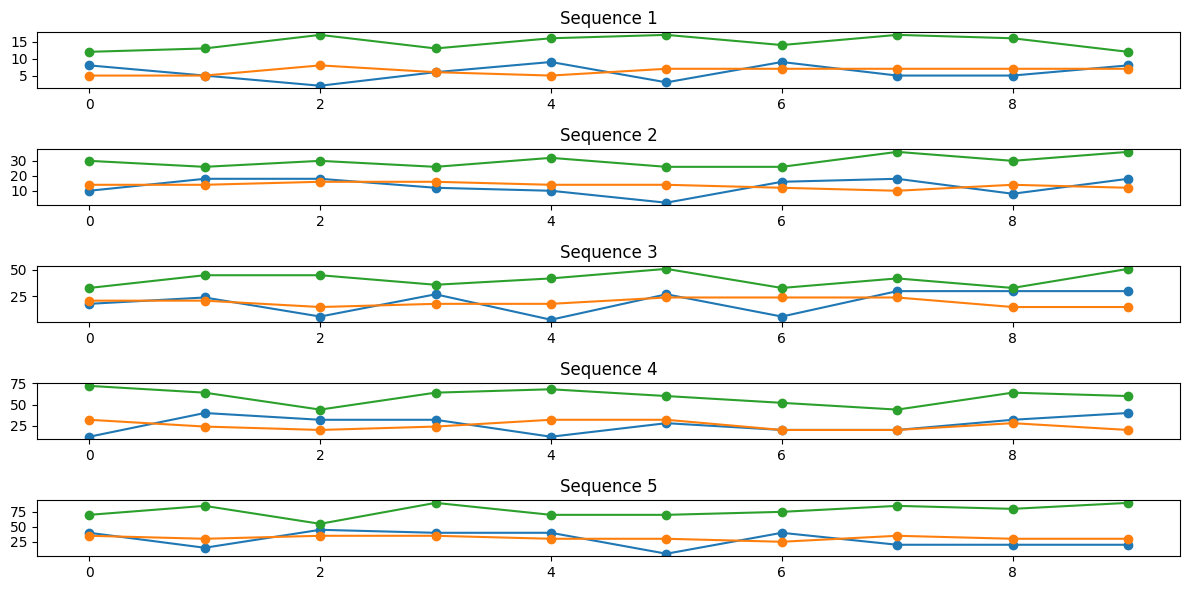

In [10]:
import numpy as np
import pandas as pd
import ast

# Load and parse the CSV data
def load_and_parse_data(file_path):
    data = pd.read_csv(file_path, header=None)
    sequences = []
    for index, row in data.iterrows():
        # Convert the row from string representation to list of lists of integers
        sequence = ast.literal_eval(row[0])
        sequences.append(sequence)
    return np.array(sequences)

# Split sequences into input and target
def split_sequences(sequences):
    inputs = []
    targets = []
    for seq in sequences:
        mid = len(seq) // 2
        inputs.append(seq[:mid])
        targets.append(seq[mid:])
    return np.array(inputs), np.array(targets)

# Load and preprocess the data
file_path = 'fake_data.csv'  # replace with your file path
sequences = load_and_parse_data(file_path)
inputs, targets = split_sequences(sequences)

print(inputs)
print(targets)



In [3]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define the model parameters
num_features = 3  # Since each element in the sequence is a list of 3 integers
latent_dim = 50  # Latent dimensionality of the encoding space

# Define the encoder
encoder_inputs = Input(shape=(None, num_features))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(None, num_features))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_features, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 50),                 10800     ['input_1[0][0]']             
                              (None, 50),                                                         
                              (None, 50)]                                                         
                                                                                              

In [4]:
from sklearn.model_selection import train_test_split

# Assuming 'inputs' and 'targets' are already defined and loaded as shown in your notebook
input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Prepare decoder input data for training and testing
decoder_input_train = np.zeros_like(target_train)
decoder_input_train[:, 1:, :] = target_train[:, :-1, :]
decoder_target_train = target_train

decoder_input_test = np.zeros_like(target_test)
decoder_input_test[:, 1:, :] = target_test[:, :-1, :]
decoder_target_test = target_test

# Train the model (if not already trained)
model.fit([input_train, decoder_input_train], decoder_target_train,
          batch_size=64, epochs=50, validation_split=0.2)

# Evaluate the model on test data
test_scores = model.evaluate([input_test, decoder_input_test], decoder_target_test, verbose=1)
print(f"Test Loss: {test_scores}")


# encoder_input_data = inputs
# decoder_input_data = np.zeros_like(targets)
# decoder_input_data[:, 1:, :] = targets[:, :-1, :]  # Shifted target sequences
# decoder_target_data = targets

# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=64, epochs=50, validation_split=0.2)


Epoch 1/50
2/2 [==============================] - 3s 758ms/step - loss: 1297374.0000 - val_loss: 1395685.1250
Epoch 2/50
2/2 [==============================] - 0s 85ms/step - loss: 1297141.6250 - val_loss: 1395441.8750
Epoch 3/50
2/2 [==============================] - 0s 46ms/step - loss: 1296931.5000 - val_loss: 1395218.3750
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 1296716.7500 - val_loss: 1394966.3750
Epoch 5/50
2/2 [==============================] - 0s 37ms/step - loss: 1296513.7500 - val_loss: 1394736.0000
Epoch 6/50
2/2 [==============================] - 0s 43ms/step - loss: 1296306.6250 - val_loss: 1394504.5000
Epoch 7/50
2/2 [==============================] - 0s 38ms/step - loss: 1296075.2500 - val_loss: 1394269.2500
Epoch 8/50
2/2 [==============================] - 0s 47ms/step - loss: 1295855.8750 - val_loss: 1394046.2500
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 1295664.5000 - val_loss: 1393847.2500
Epoch 10/50
2/2 [=

In [5]:
# Define the encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Function to generate sequences
def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence
    target_seq = np.zeros((1, 1, num_features))

    # Populate the first element with a start token
    target_seq[0, 0, :] = [0, 0, 0]

    # Sampling loop
    stop_condition = False
    decoded_sequence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Append the predicted token to the decoded sequence
        decoded_sequence.append(output_tokens[0, 0, :])

        # Exit condition
        if len(decoded_sequence) >= input_seq.shape[1]:
            stop_condition = True

        # Update the target sequence
        target_seq = np.zeros((1, 1, num_features))
        target_seq[0, 0, :] = output_tokens[0, 0, :]

        # Update states
        states_value = [h, c]

    return np.array(decoded_sequence)

# Example usage
#test_input = encoder_input_data[0:1]  # Replace with actual test input
#decoded_sequence = decode_sequence(test_input)
#print("Decoded sequence:", decoded_sequence)


1/1 [==============================] - 0s 21ms/step


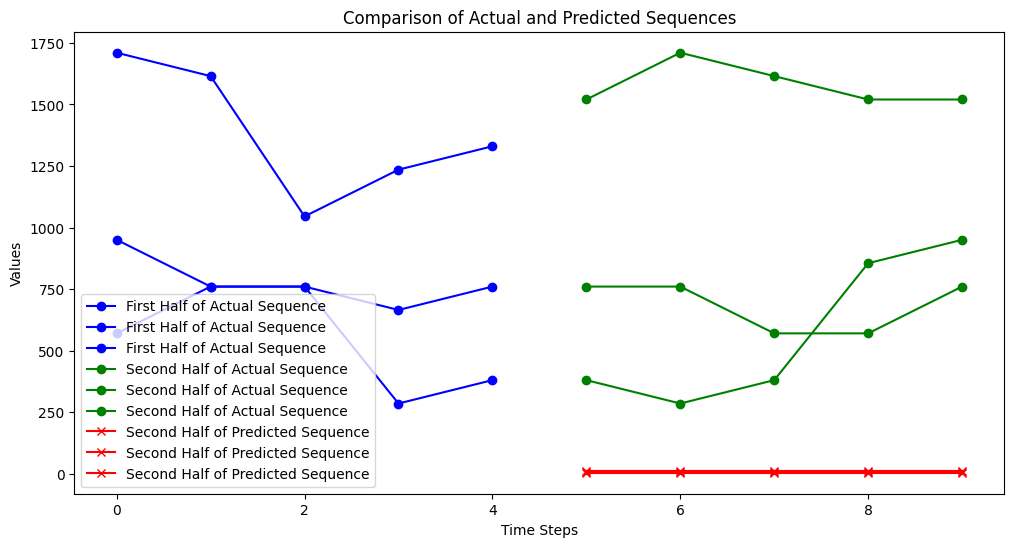

In [8]:
import matplotlib.pyplot as plt

# Generate predictions for the test data
predictions = model.predict([input_test, decoder_input_test])
predicted_sequences = [decode_sequence(pred.reshape(1, -1, num_features)) for pred in predictions]

# Select a sample to plot
sample_index = 0  # Change this index to see different samples
actual_sequence = decoder_target_test[sample_index]
predicted_sequence = predicted_sequences[sample_index]

# Determine the midpoint of the sequence for splitting
mid_point = len(actual_sequence) // 2

# Plotting
plt.figure(figsize=(12, 6))
# Plot the first half of the actual sequence
plt.plot(range(mid_point), actual_sequence[:mid_point], label='First Half of Actual Sequence', marker='o', color='blue')
# Plot the second half of the actual sequence
plt.plot(range(mid_point, len(actual_sequence)), actual_sequence[mid_point:], label='Second Half of Actual Sequence', marker='o', color='green')
# Plot the second half of the predicted sequence
plt.plot(range(mid_point, len(predicted_sequence)), predicted_sequence[mid_point:], label='Second Half of Predicted Sequence', marker='x', color='red')

plt.title('Comparison of Actual and Predicted Sequences')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()